In [181]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
from matplotlib import rcParams
from peak_utils import *
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
peak_path = project_path + '/merged_bed/MACS2/annotated'
peak_tsv = peak_path + '/unfragmented.annotated_peaks.tsv'
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype))
peak_df.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr5,140090856,140091005,unfragmented.fwd_peak_2108,944802,16330.81055,94487.18750,94480.20312,25782.0,VTRNA1-1,misc RNA,+,.,Unannotated,0.0,0.0,Sense
1,chr14,50329265,50329578,unfragmented.rvs_peak_6254,797100,14712.14648,79717.42188,79710.09375,24211.0,7SLRNA,misc RNA,-,.,Unannotated,0.0,0.0,Sense
2,chr14,50053028,50053619,unfragmented.fwd_peak_743,382149,7339.72070,38221.47656,38214.96875,14409.0,7SLRNA,misc RNA,+,"NCBP2,GEMIN5",RBP,0.0,0.0,Sense
3,chr1,28975111,28975246,unfragmented.fwd_peak_53,119618,2297.73364,11968.23242,11961.88867,4467.0,RNU11,snRNA,+,.,Unannotated,0.0,0.0,Sense
4,chr5,140098506,140098621,unfragmented.fwd_peak_2109,56467,1220.64233,5652.99072,5646.74316,1744.0,VTRNA1-2,misc RNA,+,.,Unannotated,0.0,0.0,Sense


In [183]:
peak_df.is_sense.unique()

array(['Sense', 'Antisense', 'Unannotated'], dtype=object)

In [184]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(123)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)

In [185]:
peak_df\
        .assign(peak_count = 1)\
        .groupby(['sense_gtype', 'pileup'], as_index=False)\
        .agg({'peak_count':'sum'}) \
        .sort_values('pileup')\
        .reset_index() \
        .assign(cum_count = lambda d: d.groupby('sense_gtype').peak_count.cumsum())\
        .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
        .query('sense_gtype == "Long RNA"')

,index,sense_gtype,pileup,peak_count,cum_count,log_pile
0,0,Long RNA,1.0,2754,2754,0.000000
9,1,Long RNA,2.0,663,3417,0.301030
19,2,Long RNA,3.0,150,3567,0.477121
28,3,Long RNA,4.0,56,3623,0.602060
36,4,Long RNA,5.0,47,3670,0.698970
44,5,Long RNA,6.0,24,3694,0.778151
58,6,Long RNA,7.0,33,3727,0.845098
62,7,Long RNA,8.0,10,3737,0.903090
72,8,Long RNA,9.0,15,3752,0.954243
80,9,Long RNA,10.0,12,3764,1.000000


In [186]:
peak_df.sense_gtype.unique()

array(['misc RNA', 'snRNA', 'Long RNA', 'Repeats', 'RBP', 'snoRNA',
       'miRNA', 'piRNA', 'Unannotated'], dtype=object)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_figure.pdf


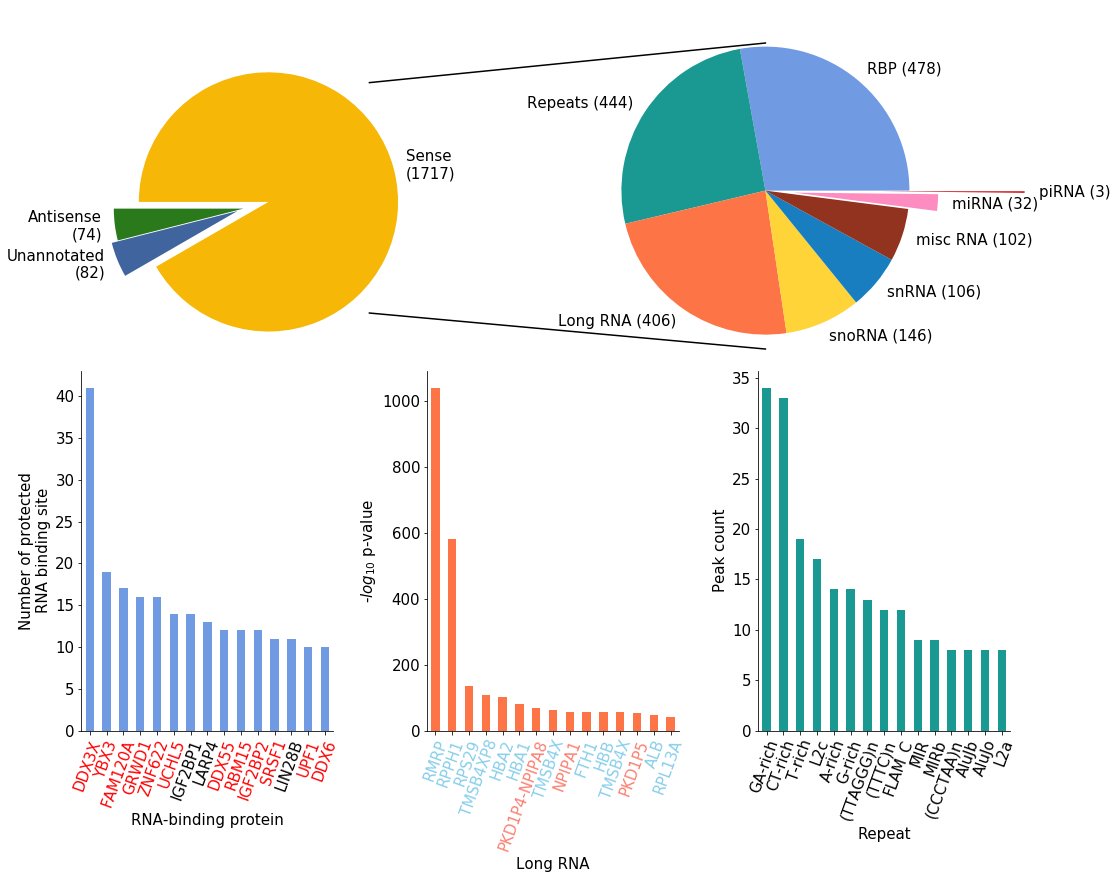

In [187]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n)
l1 = mlines.Line2D([0.3,0.85],[0.9,0.955], color= 'black',
                   figure = fig,  transform=fig.transFigure)
l2 = mlines.Line2D([0.3,0.85],[0.58,0.53], color= 'black',
                   figure = fig,  transform=fig.transFigure)
fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [190]:
peak_df\
    .pipe(lambda d: d[d.sense_gname.str.contains('FAM120A')])\
    .query('pileup>=3') \
    .sort_values('pileup', ascending=False)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
399,chr19,1272776,1273020,unfragmented.fwd_peak_1143,108,6.00430,15.65481,10.87445,8.0,FAM120A,RBP,+,piR-hsa-7551,piRNA,2.214063e-16,1.392158e-14,Sense
1352,chr4,103718067,103718616,unfragmented.rvs_peak_15607,34,3.00221,7.31962,3.42649,5.0,FAM120A,RBP,-,LOC102723704,Long RNA,4.790491e-08,5.453571e-07,Sense
556,chr19,48287785,48287901,unfragmented.fwd_peak_1234,73,4.66713,12.09309,7.39684,4.0,FAM120A,RBP,+,.,Unannotated,8.070678e-13,3.663586e-11,Sense
861,chr17,46137216,46137288,unfragmented.fwd_peak_1045,52,3.96771,9.74114,5.24864,3.0,FAM120A,RBP,+,.,Unannotated,1.814931e-10,5.207622e-09,Sense
941,chrX,38145086,38145177,unfragmented.rvs_peak_22714,50,3.96173,9.44644,5.01612,3.0,FAM120A,RBP,-,RP5-972B16.2,Long RNA,3.577338e-10,9.208930e-09,Sense
986,chr20,43535321,43535462,unfragmented.fwd_peak_1544,48,3.70664,9.39525,4.82730,3.0,FAM120A,RBP,+,.,Unannotated,4.024853e-10,1.015213e-08,Sense
1008,chr17,56422964,56423052,unfragmented.rvs_peak_8795,47,3.91112,9.12276,4.74931,3.0,FAM120A,RBP,-,TSPOAP1-AS1,Long RNA,7.537720e-10,1.794510e-08,Sense
1228,chr19,582954,583348,unfragmented.fwd_peak_1138,38,3.56360,8.12771,3.88729,3.0,FAM120A,RBP,+,.,Unannotated,7.452294e-09,1.448899e-07,Sense
1256,chr1,145441481,145441608,unfragmented.fwd_peak_138,37,3.38995,7.95994,3.77972,3.0,FAM120A,RBP,+,.,Unannotated,1.096630e-08,2.084072e-07,Sense
1375,chr17,292144,292301,unfragmented.rvs_peak_8218,33,3.28867,7.37461,3.32555,3.0,FAM120A,RBP,-,.,Unannotated,4.220754e-08,5.417255e-07,Sense


In [191]:
','.join(rbp_df.head(15).index)

'DDX3X,YBX3,FAM120A,GRWD1,ZNF622,UCHL5,IGF2BP1,LARP4,DDX55,RBM15,IGF2BP2,SRSF1,LIN28B,UPF1,DDX6'

In [192]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


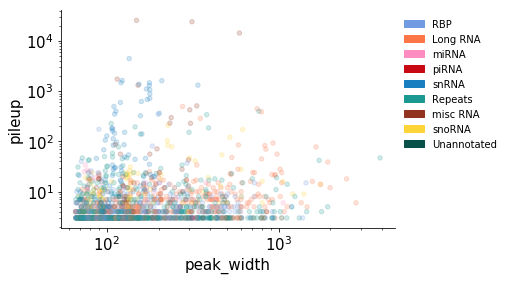

In [193]:
ax = plt.subplot()
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
    .plot.scatter('peak_width','pileup', 
                  color = ce.transform(peak_df.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


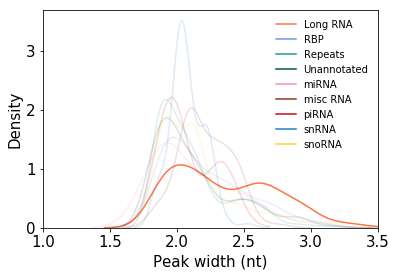

In [194]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: np.log10(d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 0.15
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width (nt)')

x_range = np.arange(1,4, 0.5)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_qc.pdf


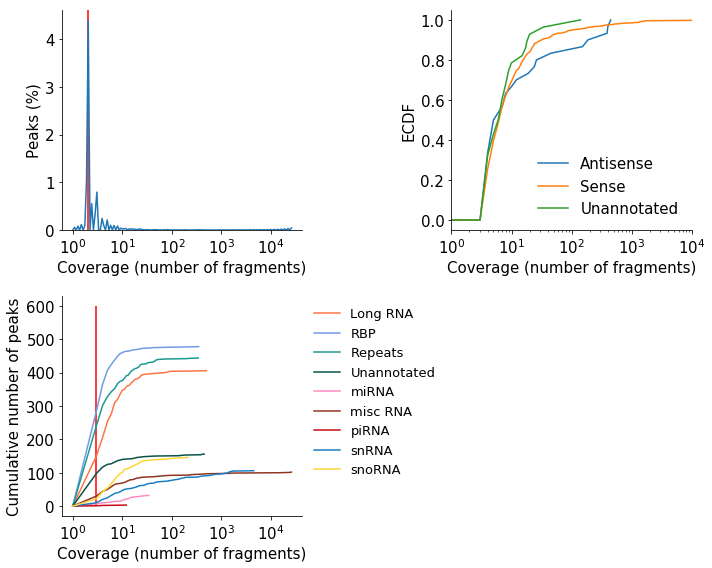

In [196]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)



In [198]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
26,chr9,35657742,35658018,unfragmented.rvs_peak_21687,10326,254.26582,1038.69763,1032.63770,497.0,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
31,chr14,20811226,20811576,unfragmented.rvs_peak_6041,5740,154.42589,579.97034,574.07294,287.0,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
62,chr14,50052670,50053597,unfragmented.rvs_peak_6249,1299,44.71004,135.03600,129.93764,93.0,RPS29,Long RNA,-,RPS29,Long RNA,9.204496e-136,3.557673e-133,Sense
69,chr4,91759634,91760217,unfragmented.rvs_peak_15534,1026,31.32246,107.87585,102.66117,85.0,AC019188.1,Long RNA,-,CCSER1,Long RNA,1.330914e-108,4.602686e-106,Sense
71,chr16,222875,223705,unfragmented.fwd_peak_889,973,35.12248,102.82503,97.33382,83.0,HBA2,Long RNA,+,.,Unannotated,1.496132e-103,5.041390e-101,Sense
82,chr16,226679,227521,unfragmented.fwd_peak_890,750,28.34839,80.44004,75.06691,70.0,HBA1,Long RNA,+,.,Unannotated,3.630446e-81,1.072124e-78,Sense
90,chr16,16468913,16469003,unfragmented.fwd_peak_916,634,23.55909,69.00220,63.47155,23.0,RP11-958N24.2,Long RNA,+,.,Unannotated,9.949471e-70,2.695896e-67,Sense
102,chr1,42965448,42965982,unfragmented.rvs_peak_434,570,18.70778,61.79586,57.04602,48.0,RP11-163G10.3,Long RNA,-,CCDC30,Long RNA,1.600074e-62,3.823158e-60,Sense
107,chr16,15027133,15027223,unfragmented.fwd_peak_911,515,21.05987,57.01128,51.57395,21.0,RP11-958N24.1,Long RNA,+,.,Unannotated,9.743612e-58,2.226881e-55,Sense
109,chr11,61734794,61735128,unfragmented.rvs_peak_3615,511,17.88978,56.24818,51.12750,34.0,FTH1,Long RNA,-,.,Unannotated,5.647029e-57,1.279490e-54,Sense


In [203]:
anti_plot

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
20726,chr14,50329268,50329569,unfragmented.fwd_peak_745,3742,118.19997,380.17014,374.25122,152.0,.,Unannotated,+,RN7SL2,misc RNA,0.000000e+00,0.000000e+00,Antisense
20729,chr11,5275567,5275958,unfragmented.fwd_peak_378,1592,54.42594,164.28525,159.20097,186.0,.,Unannotated,+,SND1,RBP,5.185015e-165,2.198028e-162,Antisense
20732,chr5,140090858,140090956,unfragmented.rvs_peak_17230,584,22.98386,63.75806,58.44144,26.0,.,Unannotated,-,VTRNA1-1,misc RNA,1.745581e-64,4.248065e-62,Antisense
20733,chr17,33981897,33982065,unfragmented.rvs_peak_8547,363,14.45949,41.40778,36.35812,24.0,.,Unannotated,-,AP2B1,Long RNA,3.910389e-42,6.761629e-40,Antisense
20738,chrX,12994372,12995344,unfragmented.rvs_peak_22578,209,9.47509,25.83812,20.94777,19.0,.,Unannotated,-,TMSB4X,Long RNA,1.451710e-26,1.609929e-24,Antisense
20742,chr14,50320392,50320633,unfragmented.fwd_peak_744,156,8.12239,20.64127,15.67663,10.0,.,Unannotated,+,RN7SL3,misc RNA,2.284178e-21,1.961930e-19,Antisense
20743,chr6,52860416,52860713,unfragmented.rvs_peak_18100,151,9.37904,20.02337,15.16892,12.0,.,Unannotated,-,RN7SK,snRNA,9.476108e-21,7.734800e-19,Antisense
20744,chr12,120729590,120729707,unfragmented.fwd_peak_629,127,6.54312,17.64370,12.78328,8.0,.,Unannotated,+,RNU4-2,snRNA,2.271433e-18,1.676969e-16,Antisense
20751,chr14,35015920,35016059,unfragmented.rvs_peak_6165,83,5.01582,12.86345,8.35627,7.0,.,Unannotated,-,RNU1-27P,snRNA,1.369462e-13,6.829900e-12,Antisense
20753,chr11,14243028,14243120,unfragmented.rvs_peak_3306,78,4.74275,12.50708,7.85066,4.0,.,Unannotated,-,SPON1,Long RNA,3.111143e-13,1.484032e-11,Antisense


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_anti.pdf


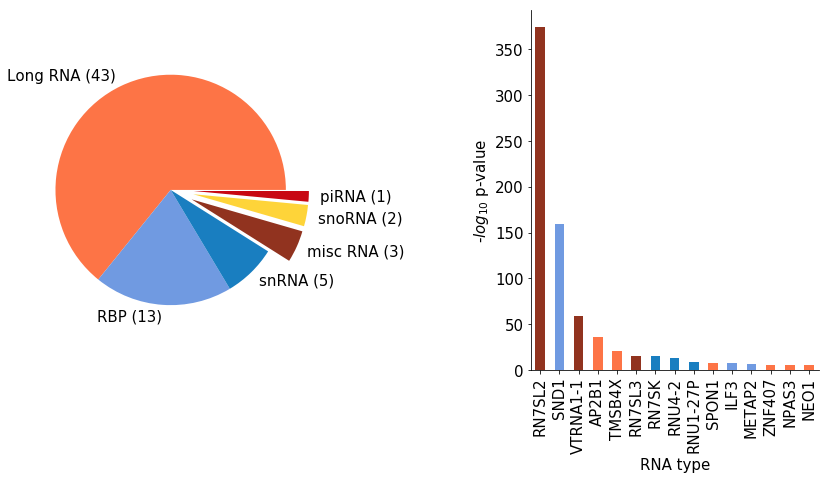

In [201]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.head(15)
anti_plot.plot\
    .bar('antisense_gname', 'log10q', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [43]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

'TTTACCCAAATAAAGTATAGGTGATAGAAATTGTATCTTGACGCAATAGATATAGTACCGCAAGGGAAAGATGACAAAACATAACCAAGCATAAAATAG'

In [132]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df)\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8, s=True, wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(81, 28)

In [150]:
intron_df.columns

Index(['chrom', 'start', 'end', 'peakname', 'score', 'strand', 'fc', 'log10p',
       'log10q', 'pileup', 'gname', 'gstrand', 'gtype', 'gid',
       'picked_RNA_anti', 'picked_type_anti', 'picked_RNA_sense',
       'picked_type_sense', 'pvalue', 'merged_type', 'FDR', 'is_sense',
       'intron_chrom', 'intron_start', 'intron_end', 'intron_gene',
       'intron_score', 'intron_strand'],
      dtype='object')

In [169]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []

for i, intron in intron_df.query('pileup >=3').iterrows():
    intron_seq = fa.fetch(intron['chrom'], intron['intron_start'] - 1, intron['intron_end'])
    intron_seq = intron_seq if intron['strand'] == "+" else reverse_complement(intron_seq)
    seqs.append(intron_seq)
    if intron_seq == "GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTCCTGCCCCTCAGCCTCACCTGTGTGGCCTCCTCTCCTCCACACAG":print(intron)
    ss_dinucleotide[intron_seq[:2] + ':' + intron_seq[-2:]] += 1
    ss_dinucleotide_seq[intron_seq[:2] + ':' + intron_seq[-2:]].append((intron['chrom'] + ':' +\
                                                                        str(intron['intron_start']) + '-'+\
                                                                       str(intron['intron_end'])))
#    if 'DOCK6' in intron['gname']  :
#        break

chrom                                                            chr16
start                                                         15027134
end                                                           15027223
peakname                                     unfragmented.fwd_peak_911
score                                                              515
strand                                                               +
fc                                                             21.0599
log10p                                                         57.0113
log10q                                                          51.574
pileup                                                              21
gname                                             RP11-958N24.1,NPIPA1
gstrand                                                            +,+
gtype                transcribed_unprocessed_pseudogene,protein_coding
gid                          ENSG00000183458.13_4,ENSG00000183426.16_3
picked

In [161]:
ss_dinucleotide

defaultdict(int, {'GT:AG': 30})

In [168]:
from collections import Counter
Counter(seqs)

Counter({'GTAAGGAGGGGGATGAGGGGTCATATCTCTTCTCAGGGAAAGCAGGAGCCCTTCAGCAGGGTCAGGGCCCCTCATCTTCCCCTCCTTTCCCAG': 1,
         'GTAGAGAGGGCAGGGTGGGCCTAGGGTGGCTGGGGATGCCAGGAGGGGCTCCTCCTCCCTCCACTCCTGCCATCCCATGACGCGCCTCCTCTCTCACGCAG': 1,
         'GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCGGAGCAATGTTGACATCACTGATGGCCACCCCTCTCCTGCAG': 1,
         'GTAGGATGATGGGGTCACGGACCAGGTCAGGGCTCACTCCCCACTGCCAGTTCCCCAAATGCTGAGTTGGCTCCTGCCCTGTCTCCTCCAG': 1,
         'GTAGGCCAGCGCCTTTGCAGGGGTCTGTGGTAGAAGGGAGACGCGGCCTCATCCGCAGCATCCTCATCCACAGCATCCTCACGGTGCCTGCCCCCAG': 1,
         'GTAGGTGGAGGGTGCAGGGGTCGGGGGCAGGGGCCCGGGGGCAGCCTGGACTCTGCTCATGTGCCCACCTGGCCACTCACCTGCAG': 1,
         'GTGAGAGGACAGCTGGGGTGGGGGCCCTTCTCCCCTTCTAATACCCACCCTGCTTTCTCCCTGTAAGCATGGCCTCCACCTCTCGTCCCCTACTGGCCTCAAGCCTCCACTGCTGTCCTCCCACAG': 1,
         'GTGAGCAGCGGGGAGGGACGGGGAGCTGGAGGGGAGCCGAGAGTATCGAGCAGGCACTGAAGCTGCGGTCCCTCCCTCTCCTCAG': 1,
         'GTGAGCTGGGGGAGGGCAGGAGGCTGGGTCCCACTCCCCCAGCCACGATGGAGGCTGGCCGACGTTTAACCTGGCTTTTCCTTTCCTCTCTGCTCA

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d

'ACCACGGCCGTTGAACATATGTCACTGGGCAGGCAGTGCCTCTACTACTGGTAATGCTAGCGGTGATGTTTTTGGTAAACAAGCTGGGTAAGATTTGCCGAGTTCCTTTTACTGTTTGTAATCTTTCCTTAGAGCATACCTGTGTTGGATTAACAGTAT'

In [131]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [132]:
print(next(aln))

0	148	-	chrM	16569	2426	2575	135	149	40	tp:A:P	ts:A:.	cg:Z:17M1D131M


In [151]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [152]:
anti = peak_df.query('pileup >= 3').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

81 seq: 15 in MT


In [153]:
anti

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,MT
20728,chr2,227586984,227587141,unfragmented.fwd_peak_1459,2680,72.40152,273.75925,268.09518,140.0,.,Unannotated,+,.,Unannotated,1.740804e-274,9.337462e-272,Unannotated,MT
20734,chr1,222984896,222985170,unfragmented.rvs_peak_1826,349,12.01115,39.27505,34.95559,34.0,.,Unannotated,-,.,Unannotated,5.308233e-40,8.559282e-38,Unannotated,no
20736,chr2,140980295,140980497,unfragmented.rvs_peak_11378,222,10.04906,26.92017,22.27997,15.0,.,Unannotated,-,.,Unannotated,1.201794e-27,1.397644e-25,Unannotated,MT
20737,chr12,22158771,22158870,unfragmented.fwd_peak_526,220,9.36087,26.88462,22.03110,20.0,.,Unannotated,+,.,Unannotated,1.304308e-27,1.510181e-25,Unannotated,MT
20739,chr2,140979201,140979904,unfragmented.rvs_peak_11377,190,8.19589,23.65310,19.01147,18.0,.,Unannotated,-,.,Unannotated,2.222798e-24,2.238383e-22,Unannotated,MT
20740,chrX,44654061,44654138,unfragmented.fwd_peak_2734,177,8.12950,22.79857,17.77446,9.0,.,Unannotated,+,.,Unannotated,1.590120e-23,1.536512e-21,Unannotated,no
20741,chr2,132141886,132141956,unfragmented.fwd_peak_1381,170,7.93465,22.09520,17.06328,7.0,.,Unannotated,+,.,Unannotated,8.031562e-23,7.472888e-21,Unannotated,no
20745,chr14,84637707,84637775,unfragmented.fwd_peak_779,123,6.37077,17.28895,12.39725,6.0,.,Unannotated,+,.,Unannotated,5.141028e-18,3.732642e-16,Unannotated,no
20746,chr2,41012102,41012256,unfragmented.fwd_peak_1307,116,6.03993,16.41665,11.61104,9.0,.,Unannotated,+,.,Unannotated,3.831334e-17,2.511196e-15,Unannotated,MT
20747,chr14,84053909,84054201,unfragmented.rvs_peak_6518,113,5.78329,15.76567,11.37457,17.0,.,Unannotated,-,.,Unannotated,1.715260e-16,1.086318e-14,Unannotated,MT
